# **<span style="color:Yellow;">Scaling, Imputing and Heatmaps with Supervised Learning</span>**

## **Purpose of Notebook**

- Load datasets
- Sample to balance size
- Encode categoricals
- Scale numericals
- Supervised imputation
- Correlation heatmap
- Feature selection (top 10)

---


## **<span style="color:aquamarine;">Load Preprocessed and Cleaned Datasets</span>**

**Load Necessary Libraries**

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, mean_squared_error
)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats
from tabulate import tabulate
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")


**Load Datasets**


In [2]:
# Display all columns of a pandas DataFrame when printed
pd.set_option('display.max_columns', None)

# US Dataset
US_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US-cleaned_data.csv')
# UK Dataset
UK_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv')
UK_data = UK_data.drop(['latitude', 'longitude'], axis=1)

print("US Dataset Shape:", US_data.shape)
print("UK Dataset Shape:", UK_data.shape)

US Dataset Shape: (4372, 21)
UK Dataset Shape: (232365, 21)


**Split the columns**
- Vital to encode the catergorical and datetime columns seperately 
- Useful when trying different imputing methods
- Allows removal on id when needed

In [ ]:
# Identify numerical and categorical columns
numerical_columns = ['Posted Speed Limit (MPH)']
categorical_columns = [
    'Make', 'Model', 'Model Year', 'ADS Equipped?',
    'Automation System Engaged?', 'City', 'State', 'Roadway Type', 'Roadway Surface',
    'Lighting', 'Crash With', 'Highest Injury Severity Alleged',
    'SV Pre-Crash Movement', 'SV Contact Area', 'Weather', 'Country'
]
datetime_columns = ['Incident Date', 'Incident Time (24:00)']
indexing_columns = ['Report ID', 'Report Version']


## **<span style="color:aquamarine;">Encode and Scale Values</span>**

### **<span style="color:Hotpink;">Encoding Function</span>**
- vital for ml models such as regression, KNN, KMeans and heatmaps as catergorical values can be used not just numerical

In [4]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_df(df, categorical_columns, datetime_columns):

    df_encoded = df.copy()
    df_encoded = df_encoded.drop(columns=indexing_columns)

    # --- Convert datetime columns to numeric ---
    if 'Incident Date' in datetime_columns:
        df_encoded['Incident Date'] = pd.to_datetime(df_encoded['Incident Date'], errors='coerce')
        df_encoded['Incident Date'] = df_encoded['Incident Date'].astype('int64') // 10**9  # Unix timestamp

    if 'Incident Time (24:00)' in datetime_columns:
        time_parsed = pd.to_datetime(df_encoded['Incident Time (24:00)'], format='%H:%M:%S', errors='coerce')
        df_encoded['Incident Time (24:00)'] = time_parsed.dt.hour * 3600 + time_parsed.dt.minute * 60 + time_parsed.dt.second

    # --- Encode categorical columns ---
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

    return df_encoded  # ✅ Return the modified DataFrame




Issue with the datetime sorted as you have to convert to nuerical not categorical for date and time!

### **<span style="color:Hotpink;">Scaling Function</span>**
- vital for ml models such as regression, KNN, KMeans and heatmaps as these models work well on unbiased standardised data

In [5]:

def scale_df(df):
    scaled_df = df.copy()
    scaler = MinMaxScaler()
    scaled_df[df.columns] = scaler.fit_transform(df)
    return scaled_df



**Encoding and Scaling UK Dataset**


In [6]:
# Encode time and categorical columns
UK_data_encoded = encode_df(UK_data.copy(), categorical_columns, datetime_columns)
# Scale the numerical features
UK_data_scale = scale_df(UK_data_encoded)
# Check encoded data
print(tabulate(UK_data_scale.head(), headers='keys', tablefmt='pretty'))


+---+---------------------+---------------------+--------------------+---------------+----------------------------+-----------------------+-----------------------+---------------------+--------------------+--------------+-----------------+--------------------------+----------+--------------------+---------------------------------+-----------------------+---------+-----------------+---------+
|   |        Make         |        Model        |     Model Year     | ADS Equipped? | Automation System Engaged? |     Incident Date     | Incident Time (24:00) |        City         |       State        | Roadway Type | Roadway Surface | Posted Speed Limit (MPH) | Lighting |     Crash With     | Highest Injury Severity Alleged | SV Pre-Crash Movement | Weather | SV Contact Area | Country |
+---+---------------------+---------------------+--------------------+---------------+----------------------------+-----------------------+-----------------------+---------------------+--------------------+----

**Encoding and Scaling US Dataset**

In [7]:
# Encode time and categorical columns
US_data_encode = encode_df(US_data.copy(), categorical_columns, datetime_columns)
# Scale the numerical features
US_data_scale = scale_df(US_data_encode)
# Check encoded data
print(tabulate(US_data_scale.head(), headers='keys', tablefmt='pretty'))


+---+---------------------+--------------------+--------------------+---------------+----------------------------+--------------------+-----------------------+--------------------+---------------------+--------------------+-----------------+--------------------------+---------------------+--------------------+---------------------------------+-----------------------+---------+--------------------+---------+
|   |        Make         |       Model        |     Model Year     | ADS Equipped? | Automation System Engaged? |   Incident Date    | Incident Time (24:00) |        City        |        State        |    Roadway Type    | Roadway Surface | Posted Speed Limit (MPH) |      Lighting       |     Crash With     | Highest Injury Severity Alleged | SV Pre-Crash Movement | Weather |  SV Contact Area   | Country |
+---+---------------------+--------------------+--------------------+---------------+----------------------------+--------------------+-----------------------+-------------------


## **<span style="color:aquamarine;">Imputing Missing Values</span>**
Experimentally, checking the error and precision for each imputing method before choosing the most accurate method which limits skewing.
### Methods of Imputing tried:
- Mean, Median, Mode
- Random 
- Last Occured Carried Forward
- Regression

**Checking how much missing data on both datasets**

In [8]:
def display_missing_values(dataset, dataset_name):
    features_with_na = [feature for feature in dataset.columns if dataset[feature].isnull().sum() > 0]
    
    # Create a PrettyTable
    table = PrettyTable()
    table.field_names = ["Feature", "Percentage of Missing Values"]
    
    for feature in features_with_na:
        missing_percentage = np.round(dataset[feature].isnull().mean() * 100, 2)
        table.add_row([feature, f"{missing_percentage} %"])
    
    print(f"Missing Values in {dataset_name}:")
    print(table)

# Check missing values for both datasets
display_missing_values(UK_data, "UK Dataset")
display_missing_values(US_data, "US Dataset")

Missing Values in UK Dataset:
+---------+------------------------------+
| Feature | Percentage of Missing Values |
+---------+------------------------------+
|  Model  |            1.11 %            |
+---------+------------------------------+
Missing Values in US Dataset:
+--------------------------+------------------------------+
|         Feature          | Percentage of Missing Values |
+--------------------------+------------------------------+
|        Model Year        |            0.32 %            |
|      Incident Date       |            0.43 %            |
|  Incident Time (24:00)   |            4.6 %             |
| Posted Speed Limit (MPH) |           11.34 %            |
+--------------------------+------------------------------+


### **<span style="color:Hotpink;">Mean/Mode Imputer</span>**
- **How it works:** Replaces missing values with the mean (for normally distributed data), or mode (for categorical variables).
- **Best for:** Small amounts of missing numerical data.
- **Limitations:** Can distort distributions and underestimate variance.

In [9]:

# Mean for numerical, Mode for categorical & datetime
def mode_mean_imputation(data, numerical_columns=None, categorical_columns=None, datetime_columns=None):
    data = data.copy()
    numerical_columns = numerical_columns or []
    categorical_columns = categorical_columns or []
    datetime_columns = datetime_columns or []

    for col in numerical_columns:
        if col in data.columns:
            data[col].fillna(data[col].mean(), inplace=True)

    for col in categorical_columns + datetime_columns:
        if col in data.columns:
            mode_val = data[col].mode()
            if not mode_val.empty:
                data[col].fillna(mode_val[0], inplace=True)
    return data


**UK Data**

In [10]:

mode_imputed_df = mode_mean_imputation(UK_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+---------------+------------------+----------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+----------------+----------------+--------------------+-------------------+----------------------------+----------------+--------------------+-----------------------------------+-------------------------+-----------+-------------------+----------------+
|    |     Report ID |   Report Version | Make     | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City           | State          | Roadway Type       | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting       | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area   | Country        |
|----+---------------+------------------+----------+---------+--------------+-----------------+------------------------------+-----------------+--------

**US Data**

In [11]:

mode_imputed_df = mode_mean_imputation(US_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

### **<span style="color:Hotpink;">Median Imputer</span>**
- **How it works:** Replaces missing values with the median (for normally distributed data), or mode (for categorical variables).
- **Best for:** Small amounts of missing numerical data.
- **Limitations:** Can distort distributions and underestimate variance.

In [12]:
# Median for numerical, Mode for categorical & datetime
def median_mode_imputation(data, numerical_columns=None, categorical_columns=None, datetime_columns=None):
    data = data.copy()
    numerical_columns = numerical_columns or []
    categorical_columns = categorical_columns or []
    datetime_columns = datetime_columns or []

    for col in numerical_columns:
        if col in data.columns:
            data[col].fillna(data[col].median(), inplace=True)

    for col in categorical_columns + datetime_columns:
        if col in data.columns:
            mode_val = data[col].mode()
            if not mode_val.empty:
                data[col].fillna(mode_val[0], inplace=True)
    return data

**UK Data**

In [13]:

median_imputed_df = median_mode_imputation(UK_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(median_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+---------------+------------------+----------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+----------------+----------------+--------------------+-------------------+----------------------------+----------------+--------------------+-----------------------------------+-------------------------+-----------+-------------------+----------------+
|    |     Report ID |   Report Version | Make     | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City           | State          | Roadway Type       | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting       | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area   | Country        |
|----+---------------+------------------+----------+---------+--------------+-----------------+------------------------------+-----------------+--------

**US Data**

In [14]:
median_imputed_df = median_mode_imputation(US_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(median_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

### **<span style="color:Hotpink;">Random Imputer</span>**
- **How it works:** Replaces missing by random sampling from existing values  
- **Best for:** Maintaining original distribution with enough data  
- **Limitations:** Adds randomness; may create unrealistic combinations

In [15]:
# Random fill from existing non-missing values
def random_imputation(data, numerical_columns=None, categorical_columns=None, datetime_columns=None):
    data = data.copy()
    numerical_columns = numerical_columns or []
    categorical_columns = categorical_columns or []
    datetime_columns = datetime_columns or []

    for col in numerical_columns + categorical_columns + datetime_columns:
        if col in data.columns:
            non_null_values = data[col].dropna().values
            if data[col].isnull().sum() > 0 and len(non_null_values) > 0:
                random_samples = np.random.choice(non_null_values, size=data[col].isnull().sum(), replace=True)
                data.loc[data[col].isnull(), col] = random_samples
    return data


**UK Data**

In [16]:
mode_imputed_df = random_imputation(UK_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+---------------+------------------+----------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+----------------+----------------+--------------------+-------------------+----------------------------+----------------+--------------------+-----------------------------------+-------------------------+-----------+-------------------+----------------+
|    |     Report ID |   Report Version | Make     | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City           | State          | Roadway Type       | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting       | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area   | Country        |
|----+---------------+------------------+----------+---------+--------------+-----------------+------------------------------+-----------------+--------

**US Data**

In [17]:
mode_imputed_df = random_imputation(US_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

### **<span style="color:Hotpink;">Last Occurance Carried Forward (LOCF) Imputer</span>**
- **How it works:** Replaces missing by random sampling from existing values  
- **Best for:** Maintaining original distribution with enough data  
- **Limitations:** Adds randomness; may create unrealistic combinations

In [18]:
# Backward fill for all
def last_occurrence_imputation(data, numerical_columns=None, categorical_columns=None, datetime_columns=None):
    data = data.copy()
    numerical_columns = numerical_columns or []
    categorical_columns = categorical_columns or []
    datetime_columns = datetime_columns or []

    for col in numerical_columns + categorical_columns + datetime_columns:
        if col in data.columns:
            data[col].fillna(method='bfill', inplace=True)
    return data


**UK Data**

In [19]:

# Usage example
mode_imputed_df = last_occurrence_imputation(UK_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+---------------+------------------+----------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+----------------+----------------+--------------------+-------------------+----------------------------+----------------+--------------------+-----------------------------------+-------------------------+-----------+-------------------+----------------+
|    |     Report ID |   Report Version | Make     | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City           | State          | Roadway Type       | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting       | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area   | Country        |
|----+---------------+------------------+----------+---------+--------------+-----------------+------------------------------+-----------------+--------

**US Data**

In [20]:

# Usage example
mode_imputed_df = last_occurrence_imputation(US_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

### **<span style="color:Hotpink;">Regression Imputer</span>**
- **How it works:** Predicts missing values using regression models on other features  
- **Best for:** When strong relationships exist between features  
- **Limitations:** Assumes linearity; risk of overfitting if data is small  

In [21]:

def regression_imputer(df, numerical_columns=None, categorical_columns=None, datetime_columns=None):
    df_copy = df.copy()
    
    if numerical_columns is None:
        numerical_columns = []
    if categorical_columns is None:
        categorical_columns = []
    if datetime_columns is None:
        datetime_columns = []
    
    # Impute numerical columns using IterativeImputer if any numerical columns exist
    if numerical_columns:
        imputer = IterativeImputer(random_state=0)
        imputed_num = imputer.fit_transform(df_copy[numerical_columns])
        imputed_num_df = pd.DataFrame(imputed_num, columns=numerical_columns, index=df_copy.index)
    else:
        imputed_num_df = pd.DataFrame(index=df_copy.index)
    
    # Impute categorical columns using mode if any exist
    if categorical_columns:
        imputed_cat_df = df_copy[categorical_columns].fillna(df_copy[categorical_columns].mode().iloc[0])
    else:
        imputed_cat_df = pd.DataFrame(index=df_copy.index)
    
    # Impute datetime columns using forward fill if any exist
    if datetime_columns:
        imputed_dt_df = df_copy[datetime_columns].fillna(method='ffill')
    else:
        imputed_dt_df = pd.DataFrame(index=df_copy.index)
    
    # Combine all imputed parts (only those with columns)
    imputed_df = pd.concat([df_copy.drop(columns=numerical_columns + categorical_columns + datetime_columns, errors='ignore'),
                            imputed_num_df, imputed_cat_df, imputed_dt_df], axis=1)
    # Optional: reorder columns to match original df
    imputed_df = imputed_df[df_copy.columns]
    
    return imputed_df


**UK Data**

In [22]:
imputed_data = regression_imputer(UK_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(imputed_data.head(), headers="keys", tablefmt="psql"))

+----+---------------+------------------+----------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+----------------+----------------+--------------------+-------------------+----------------------------+----------------+--------------------+-----------------------------------+-------------------------+-----------+-------------------+----------------+
|    |     Report ID |   Report Version | Make     | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City           | State          | Roadway Type       | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting       | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area   | Country        |
|----+---------------+------------------+----------+---------+--------------+-----------------+------------------------------+-----------------+--------

**US Data**

In [23]:
imputed_data = regression_imputer(US_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(imputed_data.head(), headers="keys", tablefmt="psql"))

+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

### **<span style="color:Orange;">Regression Imputer UPDATED</span>**
- only for posted speed US 11% missing 
- treat as categorical

In [24]:

imputing_df = US_data.copy()
imputing_df['Posted Speed Limit (MPH)'].isnull().sum()




496

In [25]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

def random_forest_imputer_encoded_only(original_df, encoded_df, target_column):
    # Align indices
    original_df = original_df.reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    # Ensure target is categorical and get codes
    original_df[target_column] = original_df[target_column].astype('category')
    target_codes = original_df[target_column].cat.codes.replace(-1, np.nan)  # NaNs stay NaN

    # Add target to encoded_df for modeling
    model_df = encoded_df.copy()
    model_df['target_code'] = target_codes

    # Split data
    df_not_missing = model_df[model_df['target_code'].notnull()]
    df_missing = model_df[model_df['target_code'].isnull()]

    X_train = df_not_missing.drop(columns=['target_code'])
    y_train = df_not_missing['target_code'].astype(int)
    X_pred = df_missing.drop(columns=['target_code'])

    if X_pred.empty:
        print("⚠️ No missing values to predict.")
        return encoded_df

    # Train and predict
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predicted_codes = model.predict(X_pred)

    # Fill missing values in encoded_df directly
    encoded_df.loc[df_missing.index, target_column] = predicted_codes

    return encoded_df

US_data_encoded_imputed = random_forest_imputer_encoded_only(
    original_df=imputing_df,        # for target labels
    encoded_df=US_data_scale,       # numeric, model-ready data
    target_column='Posted Speed Limit (MPH)'  # column to fill (in encoded_df)
)

# Check results
print(US_data_encoded_imputed['Posted Speed Limit (MPH)'].isnull().sum())  # should be 0


0


### Main hyperparameters in your code:
n_estimators=100
Number of trees in the forest. More trees usually improve performance but increase computation time.
random_state=42
Seed for reproducibility.

In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate_imputer_with_per_class_accuracy(original_df, encoded_df, target_column, test_size=0.2, random_state=42):
    original_df[target_column] = original_df[target_column].astype('category')
    categories = original_df[target_column].cat.categories

    # Filter non-missing rows
    non_missing_mask = original_df[target_column].notnull()
    full_data = original_df[non_missing_mask].copy()
    full_encoded = encoded_df[non_missing_mask].copy()

    # Numeric codes
    full_data['target_code'] = full_data[target_column].cat.codes

    # Randomly mask test samples
    np.random.seed(random_state)
    mask = np.random.rand(len(full_data)) < test_size
    test_indices = full_data.index[mask]

    # Train/test split
    X_train = full_encoded.drop(index=test_indices)
    y_train = full_data.loc[~mask, 'target_code']

    X_test = full_encoded.loc[test_indices]
    y_true = full_data.loc[mask, 'target_code']

    # Train model
    clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(categories)))

    total_samples = cm.sum()
    total_correct = np.trace(cm)  # total TP across all classes

    overall_accuracy = total_correct / total_samples

    results = {}

    for i, class_label in enumerate(categories):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = total_samples - TP - FP - FN

        class_accuracy = (TP + TN) / (TP + TN + FP + FN)

        results[class_label] = {
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "TN": TN,
            "Accuracy": class_accuracy
        }

    return overall_accuracy, results

overall_acc, per_class_metrics = evaluate_imputer_with_per_class_accuracy(US_data, US_data_scale, 'Posted Speed Limit (MPH)')

print(f"Overall Accuracy: {overall_acc:.4f}\n")
for cls, metrics in per_class_metrics.items():
    print(f"Class {cls}: TP={metrics['TP']}, FP={metrics['FP']}, FN={metrics['FN']}, TN={metrics['TN']}, Accuracy={metrics['Accuracy']:.4f}")



Overall Accuracy: 0.9598

Class 0.0: TP=0, FP=0, FN=0, TN=796, Accuracy=1.0000
Class 1.0: TP=0, FP=0, FN=0, TN=796, Accuracy=1.0000
Class 4.0: TP=0, FP=0, FN=0, TN=796, Accuracy=1.0000
Class 5.0: TP=0, FP=0, FN=0, TN=796, Accuracy=1.0000
Class 9.0: TP=0, FP=0, FN=0, TN=796, Accuracy=1.0000
Class 10.0: TP=0, FP=0, FN=0, TN=796, Accuracy=1.0000
Class 15.0: TP=20, FP=0, FN=2, TN=774, Accuracy=0.9975
Class 20.0: TP=14, FP=0, FN=2, TN=780, Accuracy=0.9975
Class 25.0: TP=216, FP=3, FN=0, TN=577, Accuracy=0.9962
Class 30.0: TP=54, FP=1, FN=1, TN=740, Accuracy=0.9975
Class 32.0: TP=0, FP=0, FN=1, TN=795, Accuracy=0.9987
Class 35.0: TP=60, FP=2, FN=1, TN=733, Accuracy=0.9962
Class 40.0: TP=39, FP=0, FN=2, TN=755, Accuracy=0.9975
Class 43.0: TP=0, FP=0, FN=0, TN=796, Accuracy=1.0000
Class 45.0: TP=63, FP=4, FN=4, TN=725, Accuracy=0.9899
Class 50.0: TP=20, FP=1, FN=5, TN=770, Accuracy=0.9925
Class 55.0: TP=56, FP=11, FN=1, TN=728, Accuracy=0.9849
Class 57.0: TP=0, FP=0, FN=0, TN=796, Accuracy=1.0

### **<span style="color:GreenYellow;">Evaluating: Imputing Methods</span>**
- For each column type trying every single imputing method to see which scores better 

**Support Functions for Imputer Test**

In [27]:

# ---------- helpers ---------- #
def masked_rmse(imputed, original, mask):
    """RMSE only on the cells that were masked *and* successfully imputed."""
    flat_mask = (mask & imputed.notna() & original.notna()).values.flatten()
    if not flat_mask.any():
        return np.nan
    y_true = original.values.flatten()[flat_mask]
    y_pred = imputed.values.flatten()[flat_mask]
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [28]:
def unified_imputer_test(
        data,
        numerical_columns=None,
        categorical_columns=None,
        datetime_columns=None,
        bar_width=0.6,
        figsize=(8, 5),
        rmse_bar_color="#aec6cf", # default pastel blue
        title ="Imputation Error"
):
    numerical_columns = numerical_columns or []
    categorical_columns = categorical_columns or []
    datetime_columns = datetime_columns or []

    selected = numerical_columns + categorical_columns + datetime_columns
    original = data.dropna(subset=selected)[selected].copy()

    # Create a 20% mask
    rng = np.random.default_rng(0)
    mask = pd.DataFrame(rng.random(original.shape) < 0.20,
                        index=original.index, columns=original.columns)
    masked = original.mask(mask)

    # Run imputers
    median_mode = median_mode_imputation(masked.copy(),
                                         numerical_columns, categorical_columns, datetime_columns)
    mode_mean = mode_mean_imputation(masked.copy(),
                                     numerical_columns, categorical_columns, datetime_columns)
    last_occ = last_occurrence_imputation(masked.copy(),
                                         numerical_columns, categorical_columns, datetime_columns)
    random_imp = random_imputation(masked.copy(),
                                  numerical_columns, categorical_columns, datetime_columns)
    regress_imp = regression_imputer(masked.copy(), numerical_columns, datetime_columns)  # only numerical

    imputers = {
        "Median‑Mode": median_mode,
        "Mode‑Mean": mode_mean,
        "Last Occur.": last_occ,
        "Random": random_imp,
        "Regression": regress_imp
    }

    # Compute RMSE scores only
    rmse_scores = {}
    for name, df_imp in imputers.items():
        if numerical_columns:
            rmse_scores[name] = masked_rmse(
                df_imp[numerical_columns], original[numerical_columns], mask[numerical_columns])

    # Plot RMSE only
    plt.figure(figsize=figsize)
    if rmse_scores:
        rmses = list(rmse_scores.values())
        labels_rmse = list(rmse_scores.keys())
        bars = plt.bar(labels_rmse, rmses, width=bar_width, color=rmse_bar_color)
        plt.ylabel(f"RMSE {title}")
        plt.title(f"{title}")
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        for b, v in zip(bars, rmses):
            plt.text(b.get_x() + b.get_width() / 2, b.get_height(),
                     f"{v:.3f}", ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    return {"RMSE": rmse_scores}



**Numerical Columns**

UK Numerical Imputing Results


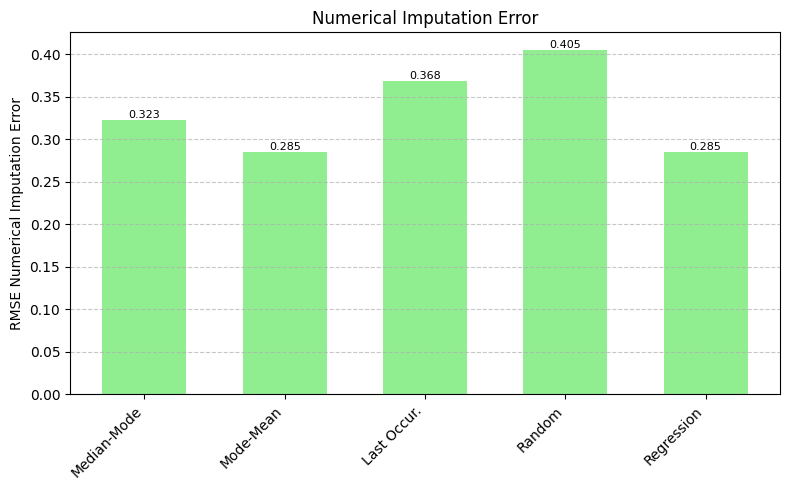

US Numerical Imputing Results


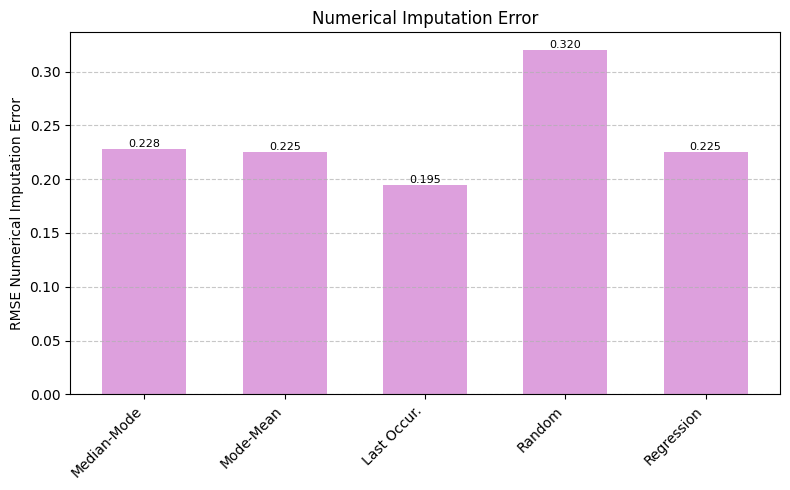

{'RMSE': {'Median‑Mode': 0.22842752228875318,
  'Mode‑Mean': 0.22530125564254685,
  'Last\xa0Occur.': 0.19494007924395984,
  'Random': 0.3204192702028236,
  'Regression': 0.22530125564254685}}

In [29]:
print("UK Numerical Imputing Results")
unified_imputer_test(UK_data_scale.copy(), numerical_columns=numerical_columns, rmse_bar_color="lightgreen",title="Numerical Imputation Error")
print("US Numerical Imputing Results")
unified_imputer_test(US_data_scale.copy(), numerical_columns=numerical_columns, rmse_bar_color="Plum",title="Numerical Imputation Error")


**Catergorical Columns**

UK Categorical Imputing Results


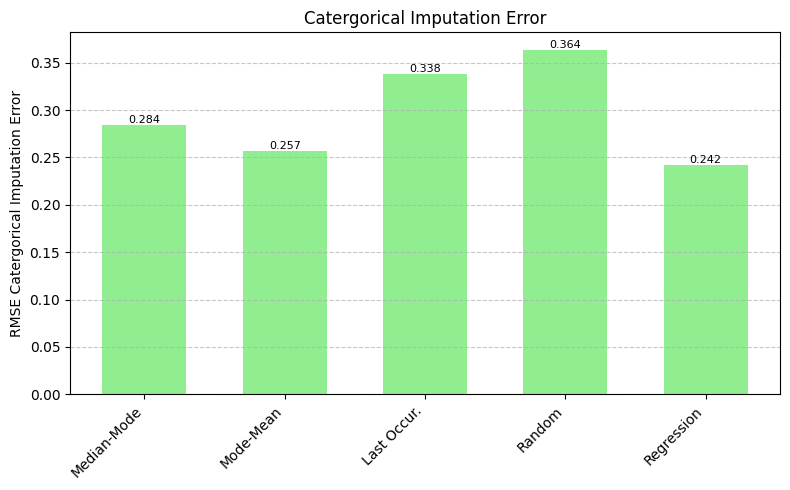

US Categorical Imputing Results


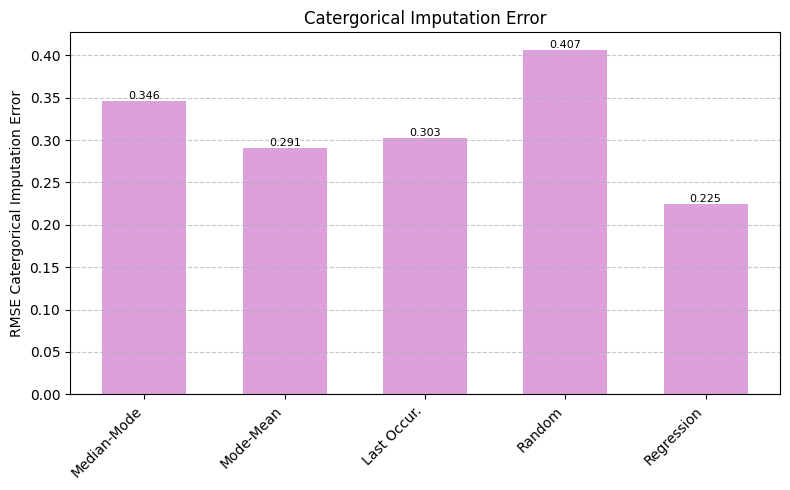

{'RMSE': {'Median‑Mode': 0.34633493010647026,
  'Mode‑Mean': 0.29098523372703333,
  'Last\xa0Occur.': 0.30253967599911463,
  'Random': 0.406695295730015,
  'Regression': 0.22469816267886414}}

In [30]:
print("UK Categorical Imputing Results")
unified_imputer_test(UK_data_scale.copy(), numerical_columns=categorical_columns,rmse_bar_color="lightgreen",title="Catergorical Imputation Error")
print("US Categorical Imputing Results")
unified_imputer_test(US_data_scale.copy(), numerical_columns=categorical_columns,rmse_bar_color="Plum",title="Catergorical Imputation Error")

**DateTime Columns**

UK Datetime Imputing Results


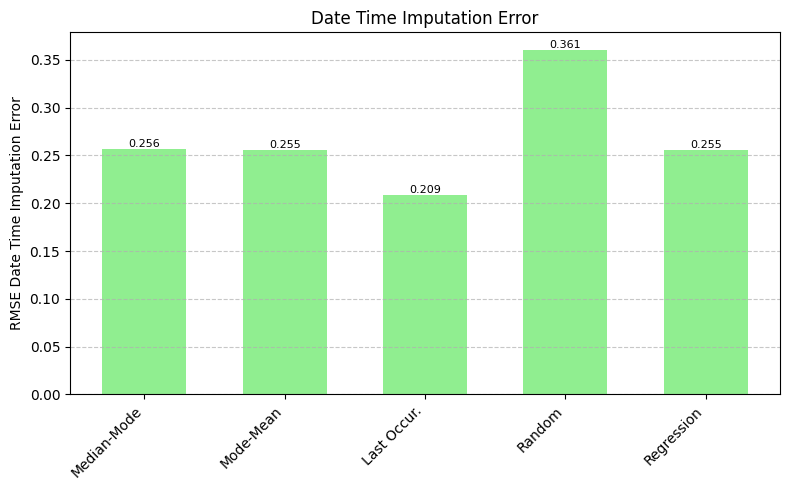

US Datetime Imputing Results


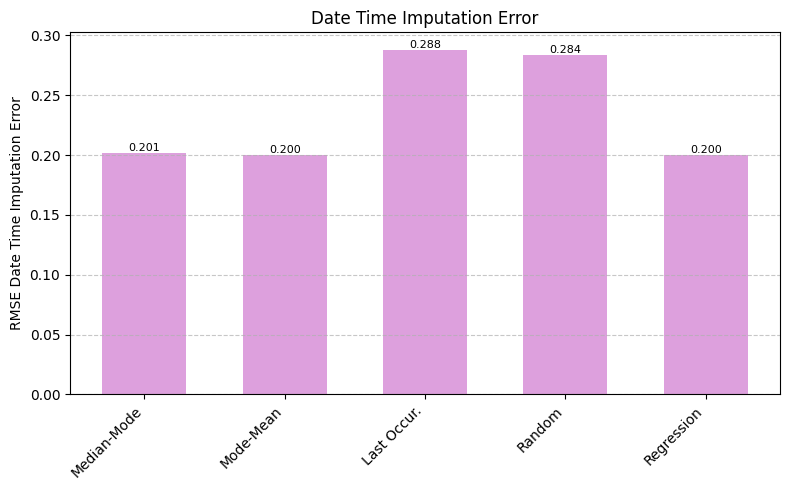

{'RMSE': {'Median‑Mode': 0.20142265645861787,
  'Mode‑Mean': 0.20049363132508458,
  'Last\xa0Occur.': 0.28822832850162916,
  'Random': 0.2836868806562968,
  'Regression': 0.20049362961481218}}

In [31]:
UK_data_scale.copy()

print("UK Datetime Imputing Results")
unified_imputer_test(UK_data_scale.copy(), numerical_columns=datetime_columns,rmse_bar_color="lightgreen",title="Date Time Imputation Error")
print("US Datetime Imputing Results")
unified_imputer_test(US_data_scale.copy(), numerical_columns=datetime_columns,rmse_bar_color="Plum",title="Date Time Imputation Error")

**Final Imputation Statergy**
- Last occured for all columns as has the least amount of error
- Note: regression can be used on catergorical as encoded 

**UK Data**
- Numerical = Mode Mean or Regression
- Catergorical = Regression
- Datetime = Last Occured

**US Data**
- Numerical = Last Occured
- Catergorical = Regression
- Datetime = Mode Mean or Mode Median or Regression 


In [32]:
# UK imputing 
scaled_encoded = UK_data_scale.copy()
final_UK_Imputing = scaled_encoded.dropna()

In [ ]:
# US imputing
scaled_encoded = US_data_scale.copy()

final_US_Imputing = random_forest_imputer_encoded_only(
    original_df=imputing_df,        # for target labels
    encoded_df=US_data_scale,       # numeric, model-ready data
    target_column='Posted Speed Limit (MPH)'  # column to fill (in encoded_df)
)
final_US_Imputing = final_US_Imputing.dropna()
print(tabulate(final_US_Imputing.head(), headers='keys', tablefmt='psql'))


+----+----------+----------+--------------+-----------------+------------------------------+-----------------+-------------------------+----------+-----------+----------------+-------------------+----------------------------+------------+--------------+-----------------------------------+-------------------------+-----------+-------------------+-----------+
|    |     Make |    Model |   Model Year |   ADS Equipped? |   Automation System Engaged? |   Incident Date |   Incident Time (24:00) |     City |     State |   Roadway Type |   Roadway Surface |   Posted Speed Limit (MPH) |   Lighting |   Crash With |   Highest Injury Severity Alleged |   SV Pre-Crash Movement |   Weather |   SV Contact Area |   Country |
|----+----------+----------+--------------+-----------------+------------------------------+-----------------+-------------------------+----------+-----------+----------------+-------------------+----------------------------+------------+--------------+---------------------------

In [34]:
# Check missing values for both datasets
display_missing_values(final_UK_Imputing, "UK Dataset")
display_missing_values(final_US_Imputing, "US Dataset")

Missing Values in UK Dataset:
+---------+------------------------------+
| Feature | Percentage of Missing Values |
+---------+------------------------------+
+---------+------------------------------+
Missing Values in US Dataset:
+---------+------------------------------+
| Feature | Percentage of Missing Values |
+---------+------------------------------+
+---------+------------------------------+



## **<span style="color:aquamarine;">Unsupervised Learning Outliers</span>**
- There are no outlier detection methods for categorical data.
- For Numerical columns only (Posted Speed Limit)

- Can return back to before encoding as Numerical columns both use Last Occured hence easily imput and remove outliers

- No outliers for datetime found in EDA but can check but... after imputing?

### **Numerical Outliers**

### **<span style="color:pink;">Z Score</span>**
Measures how many standard deviations a data point is from the mean, identifying outliers as points with a high absolute Z-score 

In [35]:
import numpy as np
from scipy import stats

def detect_outliers_zscore(df, threshold=3):
    # Ensure to select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    z_scores = np.abs(stats.zscore(numeric_df, nan_policy='omit'))
    outliers = z_scores > threshold
    return outliers

# Use only numeric columns DataFrames
uk_z_outliers = detect_outliers_zscore(UK_outlier_num_df)
print("UK outliers detected by Z-score (any feature):")
print(UK_outlier_num_df.loc[uk_z_outliers.any(axis=1)])

us_z_outliers = detect_outliers_zscore(US_outlier_num_df)
print("\nUS outliers detected by Z-score (any feature):")
print(US_outlier_num_df.loc[us_z_outliers.any(axis=1)])


NameError: name 'UK_outlier_num_df' is not defined

### **<span style="color:pink;">InterQuartile Range</span>**
Uses the range between the 25th and 75th percentiles to detect outliers as points lying below Q1 − 1.5×IQR or above Q3 + 1.5×IQR.

In [ ]:


def detect_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (df < lower_bound) | (df > upper_bound)
    return outliers
uk_iqr_outliers = detect_outliers_iqr(UK_numeric)
print("\nUK outliers detected by IQR (any feature):")
print(UK_numeric[uk_iqr_outliers.any(axis=1)])

us_iqr_outliers = detect_outliers_iqr(US_numeric)
print("\nUS outliers detected by IQR (any feature):")
print(US_numeric[us_iqr_outliers.any(axis=1)])



### **<span style="color:pink;">Boxplot</span>**
same as IQR just visual
Uses the range between the 25th and 75th percentiles to detect outliers as points lying below Q1 − 1.5×IQR or above Q3 + 1.5×IQR.

- no outliers found in either sets
- UK boxplot shows 60 and 70 to be outlier but these are totally normal motorway speeds and not caught by Z or IQR

### **<span style="color:Hotpink;">KMeans</span>**

### **<span style="color:Hotpink;">DBSCAN</span>**

### **<span style="color:Hotpink;">HDBSCAN</span>**

### **<span style="color:GreenYellow;">Evaluating: Outlier Clustering Methods</span>**
- For each column type trying every single imputing method to see which scores better 

**Final Removal of Outliers**


## **<span style="color:aquamarine;">Sampling Dataset</span>**

### **<span style="color:Hotpink;">Systematic</span>**

In [ ]:
import pandas as pd
import numpy as np

def systematic_sampling(df, sample_size=4000):
    population_size = len(df)
    step = population_size // sample_size
    start = np.random.randint(0, step)
    indices = np.arange(start, start + step * sample_size, step)
    indices = indices[indices < population_size]
    return df.iloc[indices]


### **<span style="color:Hotpink;">Stratified</span>**

In [ ]:

def stratified_sampling(df, stratify_col, frac=0.2, random_state=42):
    return df.groupby(stratify_col, group_keys=False).apply(
        lambda x: x.sample(frac=frac, random_state=random_state)
    )


### **<span style="color:Hotpink;">Random</span>**

In [ ]:
def random_sampling(df, frac=0.2, random_state=42):
    return df.sample(frac=frac, random_state=random_state)



### **<span style="color:Hotpink;">Cluster</span>**

In [ ]:
def cluster_sampling(df, cluster_col):
    clusters = df[cluster_col].unique()
    chosen_cluster = np.random.choice(clusters)
    sample = df[df[cluster_col] == chosen_cluster]
    return sample, chosen_cluster


### **<span style="color:Hotpink;">KNN</span>**

In [ ]:
def knn_sampling(df, frac=0.2):
    X = df.values
    random_point = X[np.random.choice(len(X))]
    nbrs = NearestNeighbors(n_neighbors=int(len(X)*frac)).fit(X)
    distances, indices = nbrs.kneighbors([random_point])
    return df.iloc[indices[0]]

### **<span style="color:GreenYellow;">Evaluating: Sampling Methods</span>**
- 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


# Evaluation plot function (same as yours)
def evaluate_sample(sample, full_data, name):
    means_full = full_data.mean()
    means_sample = sample.mean()
    bias = means_sample - means_full
    
    features = full_data.columns
    x = np.arange(len(features))
    width = 0.35
    
    fig, ax1 = plt.subplots(figsize=(12,6))
    rects1 = ax1.bar(x - width/2, means_full, width, label='Full Data Mean', color='skyblue')
    rects2 = ax1.bar(x + width/2, means_sample, width, label='Sample Mean', color='orange')
    ax1.set_ylabel('Mean Values')
    ax1.set_xticks(x)
    ax1.set_xticklabels(features, rotation=45, ha='right')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.plot(x, bias, color='red', marker='o', linestyle='-', label='Bias (Sample - Full)')
    ax2.set_ylabel('Bias')
    ax2.legend(loc='upper right')
    
    plt.title(f'{name} Feature-wise Mean Comparison and Bias')
    plt.tight_layout()
    plt.show()

In [ ]:

# Main function to run all samplings and evaluations
def run_all_sampling_methods(data, stratify_col):

    # 1. Random Sampling
    random_sample = random_sampling(data)
    print("Random Sampling:")
    evaluate_sample(random_sample, data, "Random ")

    # 2. Systematic Sampling
    systematic_sample = systematic_sampling(data)
    print("Systematic Sampling:")
    evaluate_sample(systematic_sample, data, "Systematic ")

    # 3. Stratified Sampling
    stratified_sample = stratified_sampling(data, stratify_col)
    print("Stratified Sampling:")
    evaluate_sample(stratified_sample, data, "Stratified ")

    # 4. Cluster Sampling
    cluster_sample, chosen_cluster = cluster_sampling(data, stratify_col)
    print(f"Cluster Sampling (cluster '{chosen_cluster}'):")
    evaluate_sample(cluster_sample, data, "Cluster ")

    # 5. KNN Sampling
    knn_sample = knn_sampling(data)
    print("KNN Sampling:")
    evaluate_sample(knn_sample, data, "KNN ")

    # Return samples if needed
    return {
        "random_sample": random_sample,
        "systematic_sample": systematic_sample,
        "stratified_sample": stratified_sample,
        "cluster_sample": cluster_sample,
        "knn_sample": knn_sample
    }


**UK Dataset**

In [ ]:
# Assuming your original data is in variable `data`
final_UK_Imputing = final_UK_Imputing.drop(columns=['ADS Equipped?', 'Automation System Engaged?'], errors='ignore')
samples = run_all_sampling_methods(final_UK_Imputing, stratify_col='Highest Injury Severity Alleged')

**US Dataset**

In [ ]:
# Assuming your original data is in variable `data`
samples = run_all_sampling_methods(final_US_Imputing, stratify_col='Highest Injury Severity Alleged')

### **Final Samples**

- sampling not required as this will be misleading


## **<span style="color:aquamarine;">Feature Selection</span>**

In [45]:
def encode_df(df, categorical_columns, datetime_columns):
    df_encoded = df.copy()

    # Convert datetime columns to numeric timestamps
    if 'Incident Date' in datetime_columns and 'Incident Date' in df_encoded.columns:
        df_encoded['Incident Date'] = pd.to_datetime(df_encoded['Incident Date'], errors='coerce')
        df_encoded['Incident Date'] = df_encoded['Incident Date'].astype('int64') // 10**9  # Unix timestamp

    if 'Incident Time (24:00)' in datetime_columns and 'Incident Time (24:00)' in df_encoded.columns:
        time_parsed = pd.to_datetime(df_encoded['Incident Time (24:00)'], format='%H:%M:%S', errors='coerce')
        df_encoded['Incident Time (24:00)'] = (
            time_parsed.dt.hour * 3600 +
            time_parsed.dt.minute * 60 +
            time_parsed.dt.second
        )

    # Encode categorical columns
    label_encoders = {}
    for col in categorical_columns:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
            label_encoders[col] = le

    return df_encoded, label_encoders


In [46]:

def scale_df(df, columns):
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df[columns])
    df_scaled = pd.DataFrame(scaled_values, columns=columns, index=df.index)
    return df_scaled, scaler


In [48]:

def plot_correlation_heatmap(df, title="Correlation Heatmap", figsize=(18, 14)):
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


## **UK Dataset**

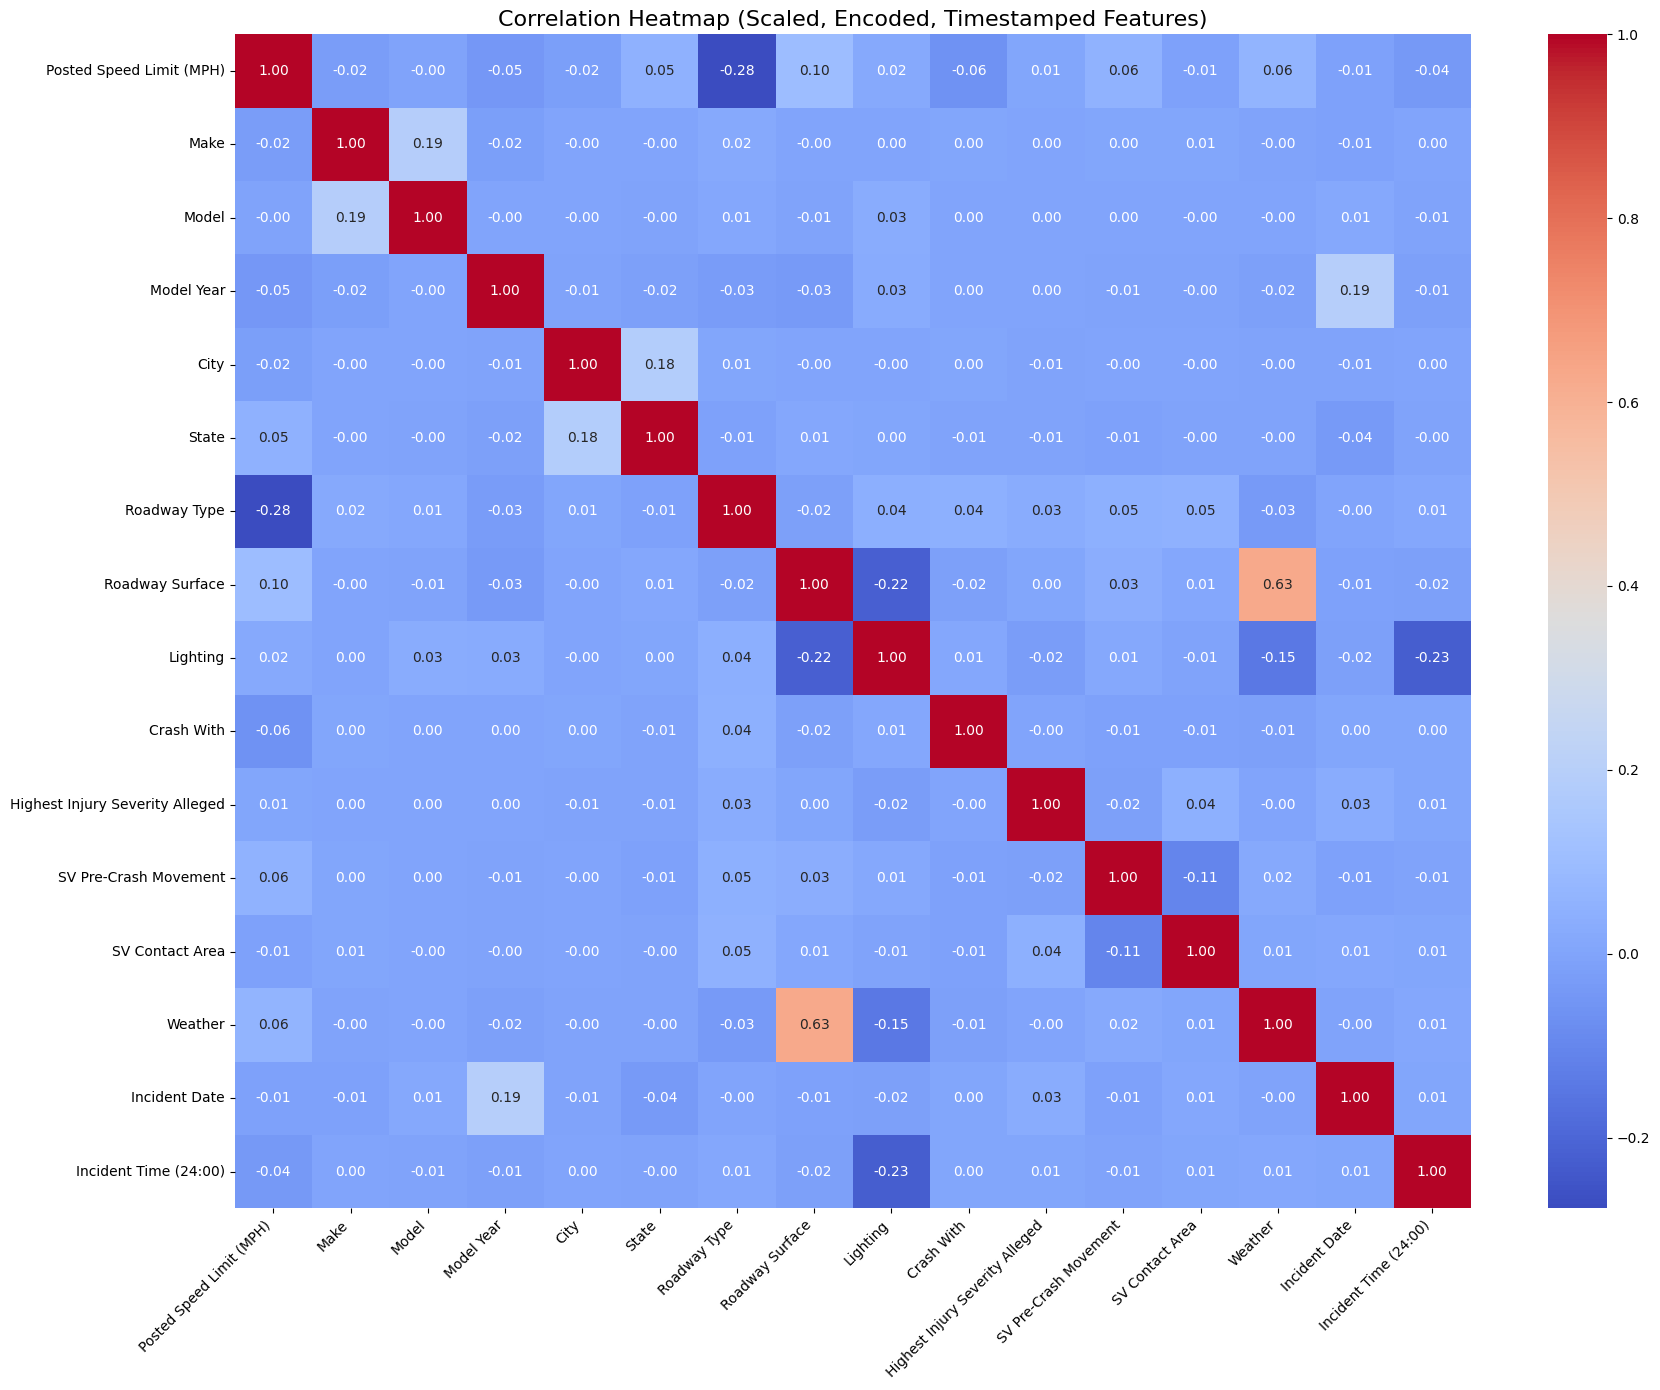

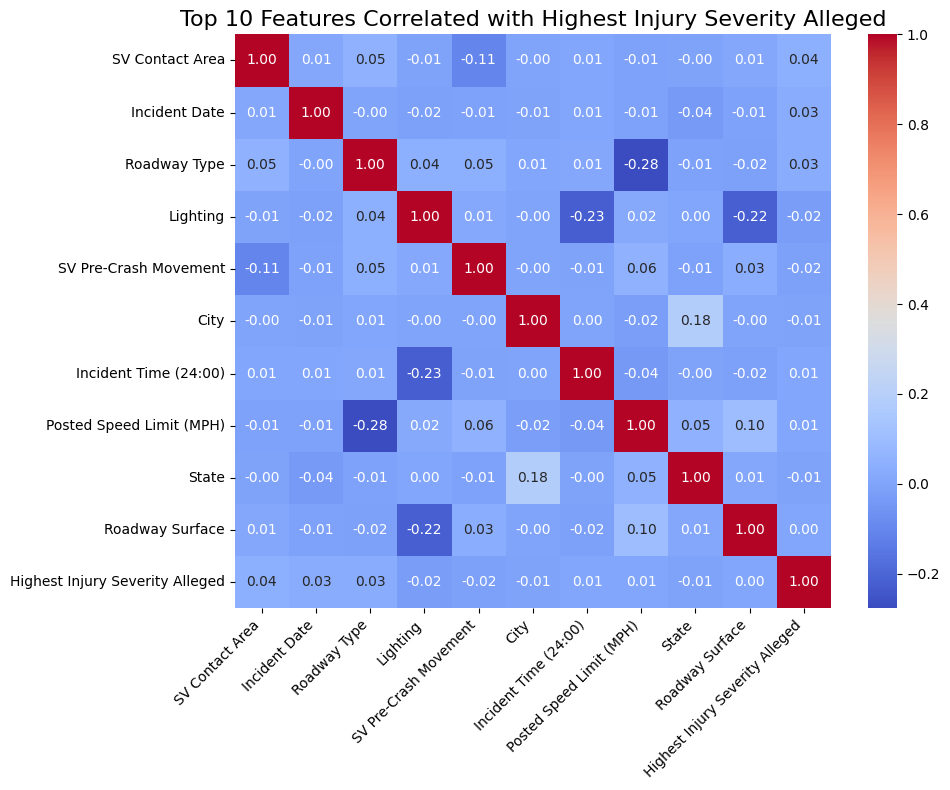

In [55]:

# === Usage Example ===

# Define columns (same as your original lists)
numerical_columns = ['Posted Speed Limit (MPH)']
categorical_columns = [
    'Make', 'Model', 'Model Year', 'City', 'State', 'Roadway Type', 'Roadway Surface',
    'Lighting', 'Crash With', 'Highest Injury Severity Alleged',
    'SV Pre-Crash Movement', 'SV Contact Area', 'Weather',
]
datetime_columns = ['Incident Date', 'Incident Time (24:00)']

# Step 1: Encode dataframe
df_encoded, encoders = encode_df(UK_data, categorical_columns, datetime_columns)

# Step 2: Select columns to scale
heatmap_columns = numerical_columns + categorical_columns + datetime_columns

# Step 3: Scale dataframe
df_scaled, scaler = scale_df(df_encoded, heatmap_columns)

# Step 5: Imputing 
df_scaled = df_scaled.dropna()

# Step 4: Plot full heatmap
plot_correlation_heatmap(df_scaled, title="Correlation Heatmap (Scaled, Encoded, Timestamped Features)")

# Step 5: Plot top 10 features correlated with 'Highest Injury Severity Alleged'
target_col = 'Highest Injury Severity Alleged'
corr_matrix = df_scaled.corr()
target_corr = corr_matrix[target_col].abs().sort_values(ascending=False)
top_features = target_corr.index.drop(target_col).to_list()
top_10_features = top_features[:10] + [target_col]

plot_correlation_heatmap(df_scaled[top_10_features], 
                         title="Top 10 Features Correlated with Highest Injury Severity Alleged", 
                         figsize=(10, 8))


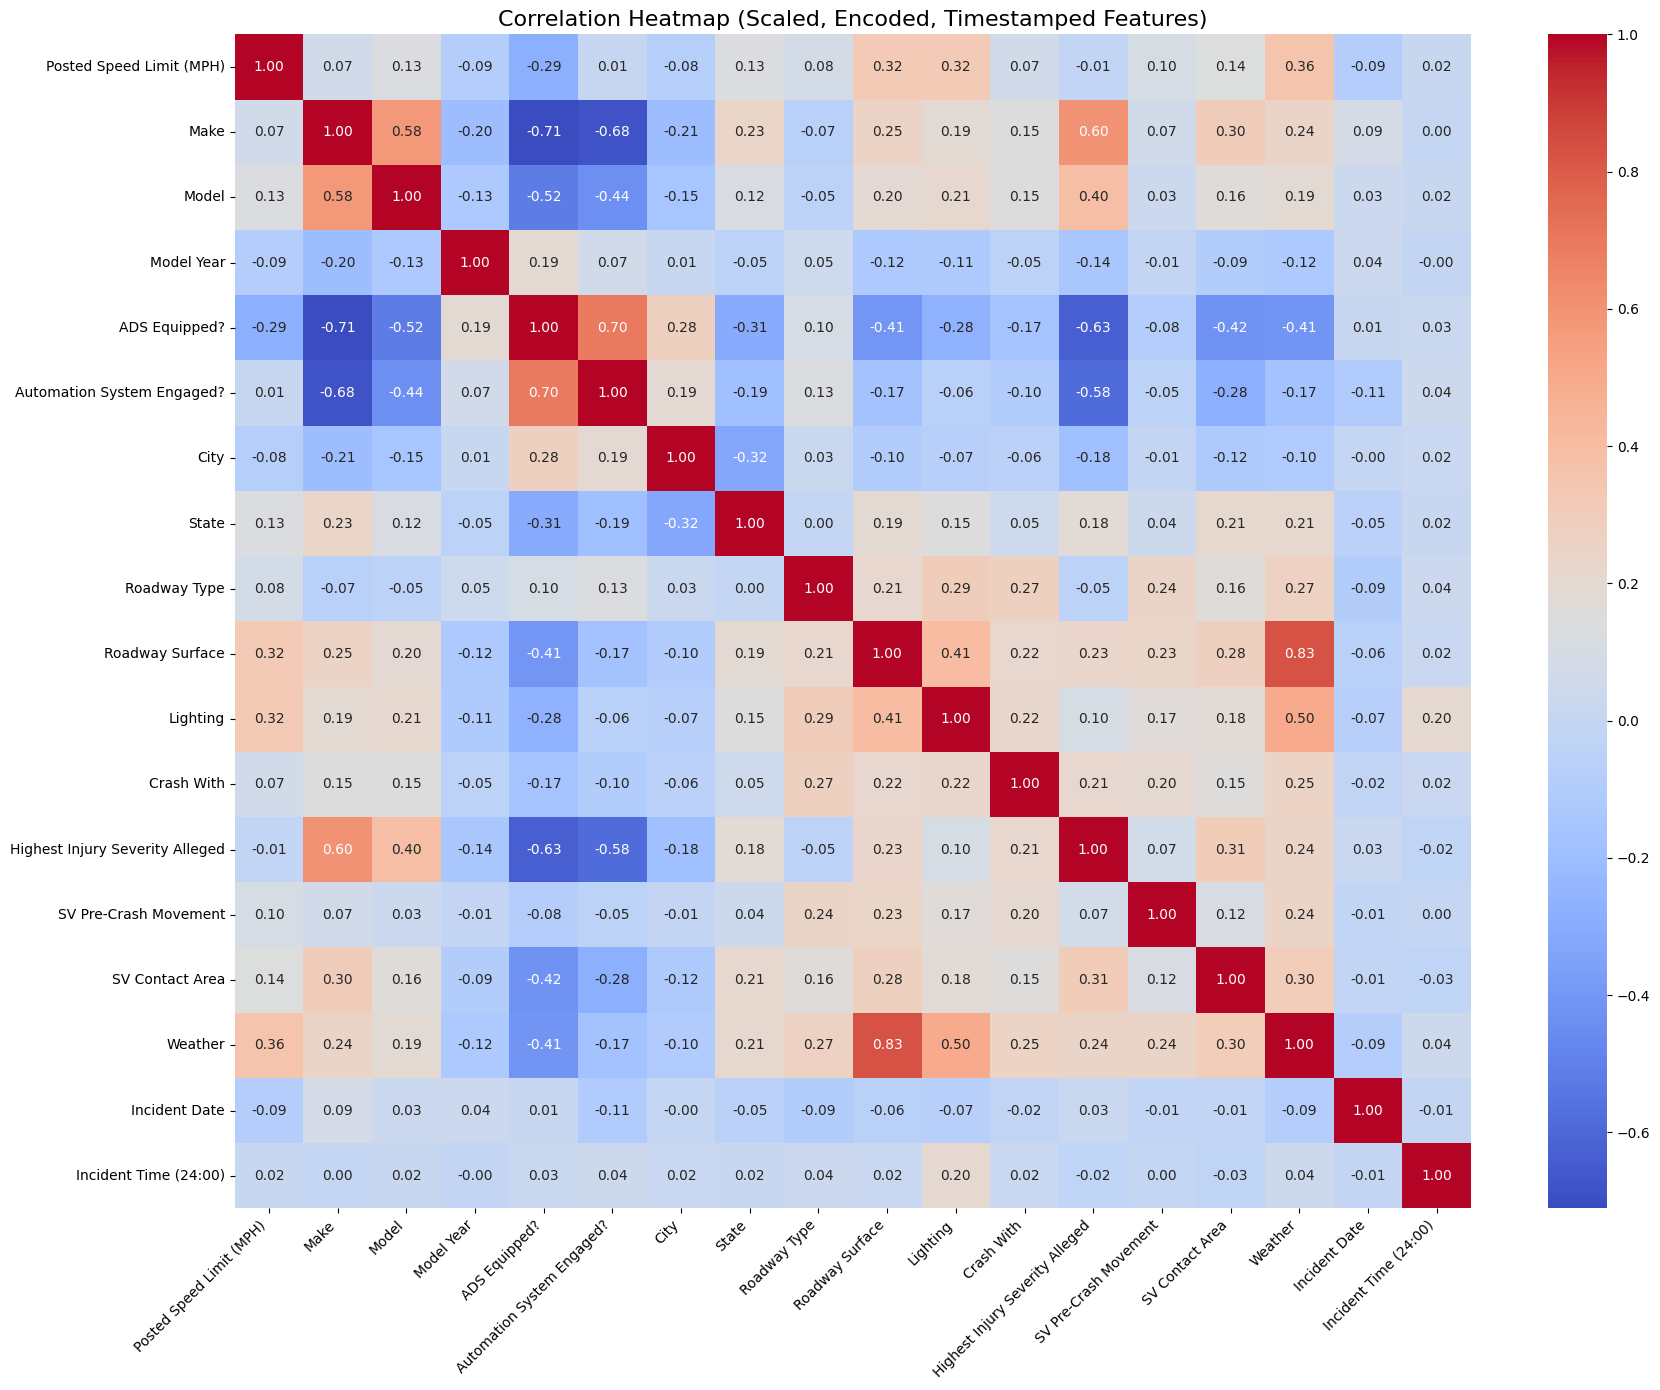

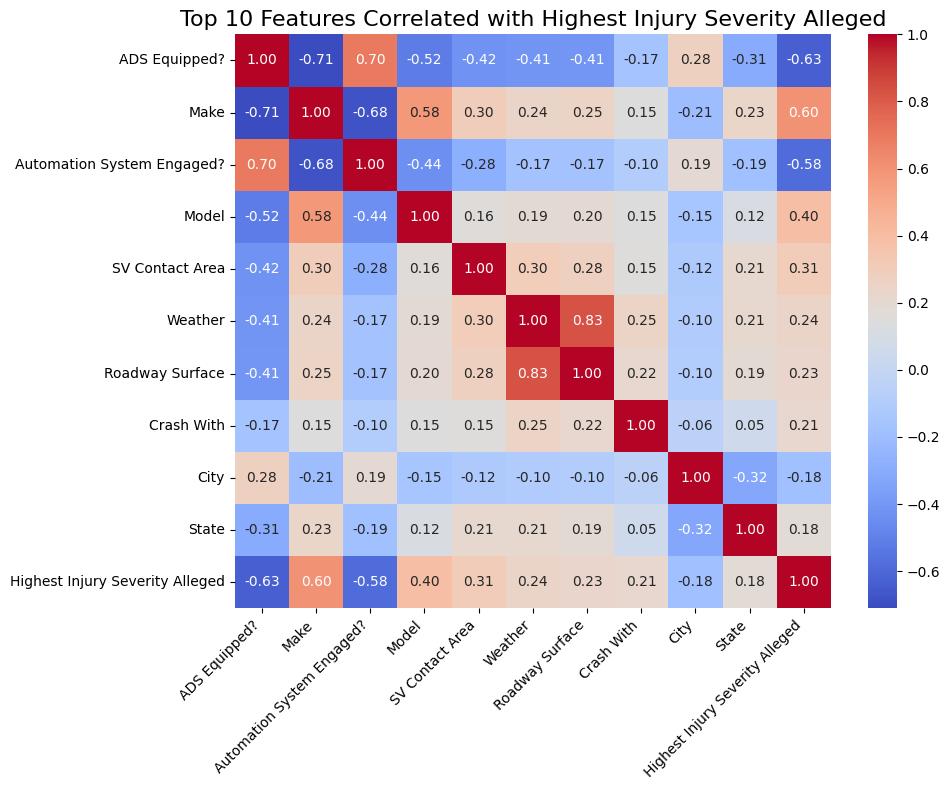

In [56]:

# === Usage Example ===

# Define columns (same as your original lists)
numerical_columns = ['Posted Speed Limit (MPH)']
categorical_columns = [
    'Make', 'Model', 'Model Year', 'ADS Equipped?',
    'Automation System Engaged?', 'City', 'State', 'Roadway Type', 'Roadway Surface',
    'Lighting', 'Crash With', 'Highest Injury Severity Alleged',
    'SV Pre-Crash Movement', 'SV Contact Area', 'Weather', 
]
datetime_columns = ['Incident Date', 'Incident Time (24:00)']

# Step 1: Encode dataframe
df_encoded, encoders = encode_df(US_data, categorical_columns, datetime_columns)

# Step 2: Select columns to scale
heatmap_columns = numerical_columns + categorical_columns + datetime_columns

# Step 3: Scale dataframe
df_scaled, scaler = scale_df(df_encoded, heatmap_columns)

# Step 5: Imputing 
final_US_Imputing = random_forest_imputer_encoded_only(
    original_df=US_data,        # for target labels
    encoded_df=df_scaled,       # numeric, model-ready data
    target_column='Posted Speed Limit (MPH)'  # column to fill (in encoded_df)
)
df_scaled = final_US_Imputing

# Step 4: Plot full heatmap
plot_correlation_heatmap(df_scaled, title="Correlation Heatmap (Scaled, Encoded, Timestamped Features)")

# Step 5: Plot top 10 features correlated with 'Highest Injury Severity Alleged'
target_col = 'Highest Injury Severity Alleged'
corr_matrix = df_scaled.corr()
target_corr = corr_matrix[target_col].abs().sort_values(ascending=False)
top_features = target_corr.index.drop(target_col).to_list()
top_10_features = top_features[:10] + [target_col]

plot_correlation_heatmap(df_scaled[top_10_features], 
                         title="Top 10 Features Correlated with Highest Injury Severity Alleged", 
                         figsize=(10, 8))